In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvista as pv
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
import seaborn as sns
import shapely
import shapely.ops
import shapely.geometry
from sklearn.cluster import KMeans
from skimage.segmentation import flood_fill, flood
from skimage import filters, measure
from itertools import tee

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return list(zip(a, b))

sns.set()

In [3]:
viet_mesh = pv.read('./viet/V2_2_105.75_15.98_tile_1_1.stl')
viet_plane = viet_mesh.project_points_to_plane().points
viet_edge = viet_mesh.project_points_to_plane().extract_feature_edges().points
viet_bounds = viet_mesh.bounds

n_pieces = 16

In [4]:
kmeans = KMeans(n_clusters=n_pieces, random_state=0).fit(viet_plane[:,:2])
clusters = kmeans.predict(viet_plane[:,:2])
vor = Voronoi(kmeans.cluster_centers_, qhull_options='Qbb Qc Qx')

region_bbox = shapely.geometry.Polygon(zip(
    [viet_plane[:,0].min()-5, viet_plane[:,0].min()-5, viet_plane[:,0].max()+5, viet_plane[:,0].max()+5, viet_plane[:,0].min()-5], 
    [viet_plane[:,1].min()-5, viet_plane[:,1].max()+5, viet_plane[:,1].max()+5, viet_plane[:,1].min()-5, viet_plane[:,1].min()-5]
))

In [5]:
viet_plane_df = pd.DataFrame(viet_plane, columns=['x','y','z'])
viet_plane_df['cluster'] = clusters

pieces = []
for g, gdf in viet_plane_df.groupby('cluster'):
    hull = ConvexHull(gdf[['x','y']].values)
    p = hull.points[hull.vertices]    
    poly = shapely.geometry.Polygon(p)
    pieces.append(poly)

In [6]:
connected_pieces = []
for idx, p0 in enumerate(pieces):
    for jdx, p1 in enumerate(pieces[idx+1:], idx+1):
        if idx == jdx: continue
        line = shapely.geometry.LineString([p0.centroid, p1.centroid])
        poly_intersections = [(i, line.intersection(p).length) for i, p in enumerate(pieces) if line.intersects(p)]
        if len(poly_intersections) == 2:
            if (poly_intersections[0][1] + poly_intersections[1][1]) / line.length > 0.9:
                connected_pieces.append([(i,pieces[i].centroid.coords[0]) for i, length in poly_intersections])
        
for (i, c0),(j,c1) in connected_pieces:
    line = shapely.geometry.LineString([c0, c1])
    near_center_point = line.interpolate(0.65, normalized=True)
    near_center_point_poly = shapely.geometry.LineString([line.coords[0], near_center_point]).buffer(0.5)
    near_center_point_buffer = near_center_point.buffer(1.5)
    x, y = near_center_point_buffer.exterior.xy
    
    x.append(x[0])
    y.append(y[0])
    near_center_point_buffer = shapely.geometry.Polygon(zip(x[::3],y[::3]))
    near_center_point_poly = shapely.ops.cascaded_union([near_center_point_poly, near_center_point_buffer])
    
    pieces[i] = shapely.ops.cascaded_union([pieces[i], near_center_point_poly]).buffer(-0.01)
    pieces[j] = pieces[j].difference(near_center_point_poly.buffer(0.01))

No handles with labels found to put in legend.


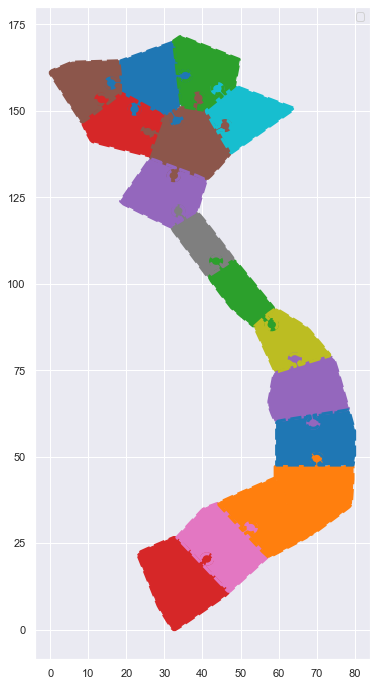

In [7]:
fig, ax = plt.subplots(1, figsize=(6,12))
# ax.scatter(viet_plane[:,0], viet_plane[:,1], c=clusters, alpha=1, s=10)
# ax.scatter(viet_edge[:,0], viet_edge[:,1], alpha=0.4)
c = plt.cm.tab10.colors
for idx, p in enumerate(pieces):
    x, y = p.exterior.xy
    plt.plot(x,y,lw=3,ls='--', c=c[idx%len(c)])
    plt.fill(x,y, c=c[idx%len(c)])
plt.legend()
plt.show()

In [8]:
pieces_3d = []

for idx, p in enumerate(pieces):
    x, y = p.buffer(-0.05).boundary.xy
    x.append(x[0])
    y.append(y[0])
    
#     mesh_verts_faces = [tc.triangulate_polygon(p) for p in pieces]
#     mesh_verts = []
#     mesh_faces = []
#     for idx, (v, f) in enumerate(mesh_verts_faces):
#         v0 = np.zeros((v.shape[0],3))
#         v0[:,:2] = v
#         v0[:,2] = viet_bounds[4]
#         mesh_verts.append(v0)
#         mesh_faces.append(f)

#     trimeshes = [pv.wrap(
#         trimesh.Trimesh(
#             vertices=v, faces=f, process=False
#         )
#     ) for v, f in zip(mesh_verts, mesh_faces)]

    
    
    
    z_low = np.full(len(x), viet_bounds[4]-1)
    z_high = np.full(len(x), viet_bounds[5]+1)
    piece_3d = np.zeros(shape=(2*len(x), 3))
    piece_3d[:,0], piece_3d[:,1] = np.hstack([x,x]), np.hstack([y,y])
    piece_3d[:,2] = np.hstack([z_low, z_high])
    
    piece_3d_lines = [[2,i,i+1] for i in range(len(x)-1)]
    piece_3d_lines.extend([[2,len(x)+i,len(x)+i+1] for i in range(len(x)-1)])
    piece_3d_lines.extend([[2,i,i+len(x)] for i in range(len(x))])

    top_face = [len(x)]
    top_face.extend(list(range(len(x))))
    bot_face = [len(x)]
    bot_face.extend(list(range(len(x), 2*len(x))))

    side_faces = [[4,idx,idx+1,idx+len(x)+1,idx+len(x)] for idx in range(len(x)-1)]
    side_faces.append([4,0,len(x)-1,2*len(x)-1,len(x)])
    side_faces = np.vstack(side_faces)

    faces = np.hstack([top_face, bot_face])
    faces = np.append(faces, side_faces)

    piece_3d = pv.PolyData(piece_3d, faces)
    piece_3d['my labels'] = [f"idx:{i}" for i in range(piece_3d.n_points)]


    piece_3d.lines = piece_3d_lines
    piece_3d = piece_3d.clip_surface(piece_3d)

    pieces_3d.append(piece_3d)

In [9]:
import trimesh.path.polygons as tpp
import trimesh.creation as tc

# mesh_pieces = []
# for p in pieces:
#     mesh_piece = []
#     for t in tc.extrude_polygon(p, 1).triangles:
#         t = np.vstack([t, [t[0]]])
#         mesh_piece.append(t)
#         plt.plot(t[:,0], t[:,1])
#     mesh_pieces.append(mesh_piece)
#     plt.show()
    
# mesh_pieces = [tc.extrude_polygon(p, 1).triangles for p in pieces]

In [10]:
import trimesh
m = trimesh.load('./viet/V2_2_105.75_15.98_tile_1_1.stl')
print(m.is_watertight)
# m.show()

face_normals all zero, ignoring!


True


In [11]:
import trimesh
points = [[0, 0, 0], [0, 0, 1], [0, 1, 0]]
faces = [[0, 1, 2]]
tmesh = trimesh.Trimesh(points, faces=faces, process=False)
mesh = pv.wrap(tmesh)
print(mesh)
print(type(tmesh))

print(type(tc.triangulate_polygon(pieces[0])))

PolyData (0x15898d820)
  N Cells:	1
  N Points:	3
  X Bounds:	0.000e+00, 0.000e+00
  Y Bounds:	0.000e+00, 1.000e+00
  Z Bounds:	0.000e+00, 1.000e+00
  N Arrays:	0

<class 'trimesh.base.Trimesh'>
<class 'tuple'>


In [31]:
import trimesh


mesh_verts_faces = [tc.triangulate_polygon(p) for p in pieces]
mesh_verts = []
mesh_faces = []
for idx, (v, f) in enumerate(mesh_verts_faces):
    v0 = np.zeros((v.shape[0]*2,3))
    v0[:,:2] = np.vstack([v,v])
    v0[:len(v),2] = viet_bounds[4] - 1
    v0[len(v):,2] = viet_bounds[5] + 1
    
    f0 = np.vstack([f,f])
    f0[len(v):] += len(v)
    
    side_f = []
    for i in range(0,len(v),2):
        side_f.append([i,i+1,len(v)+i-1])
        side_f.append([i+1,len(v)+i-1,len(v)+i])
    
    f0 = np.vstack([f0, side_f])
        
    mesh_verts.append(v0)
    mesh_faces.append(f0)

trimeshes = [
    trimesh.Trimesh(vertices=v, faces=f, process=False) 
    for v, f in zip(mesh_verts, mesh_faces)
]
[
    [
        trimesh.repair.fill_holes(t),
        trimesh.repair.fix_normals(t),
        trimesh.repair.fix_winding(t),
    ]
    for t in trimeshes
]
print([t.is_watertight for t in trimeshes])

p = pv.Plotter(notebook=False)
for tm in trimeshes:
    p.add_mesh(pv.wrap(tm), show_edges=True, opacity=0.6)
p.show()



print(trimeshes[0].bounds)
print(trimeshes[1].bounds)
print('2')

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[[ 14.53158551 145.75957264  -1.        ]
 [ 36.98234101 169.79933202  15.45563221]]
[[59.09692337 27.51151401 -1.        ]
 [79.56974457 50.96076628 15.45563221]]
2


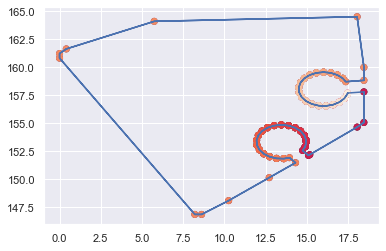

In [22]:
plt.scatter(v0[:,0], v0[:,1], c=list(range(len(v0))))
plt.plot(v0[:,0], v0[:,1])
plt.show()

In [134]:
help(trimesh.util.submesh) # submesh

Help on function submesh in module trimesh.util:

submesh(mesh, faces_sequence, repair=True, only_watertight=False, min_faces=None, append=False)
    Return a subset of a mesh.
    
    Parameters
    ------------
    mesh : Trimesh
       Source mesh to take geometry from
    faces_sequence : sequence (p,) int
        Indexes of mesh.faces
    only_watertight : bool
        Only return submeshes which are watertight.
    append : bool
        Return a single mesh which has the faces appended,
        if this flag is set, only_watertight is ignored
    
    Returns
    ---------
    if append : Trimesh object
    else        list of Trimesh objects



In [99]:
mesh_piece = mesh_pieces[0]
piece = np.vstack(pieces[0].exterior.xy).T
np.where(mesh_piece[0][0,:2] == piece), np.where(mesh_piece[0][1,:2] == piece)
# surf = pv.PolyData(vertices, faces)


NameError: name 'mesh_pieces' is not defined

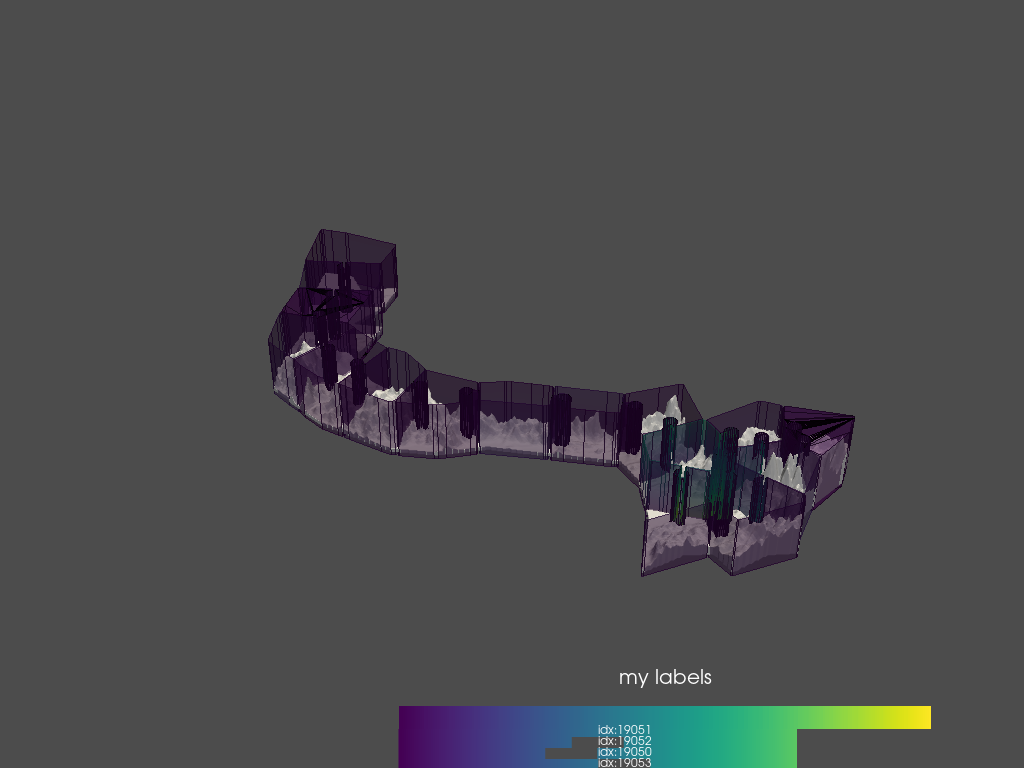

[(251.8547644369714, 297.5983557455652, 219.08258054186032),
 (40.0, 85.74359130859375, 7.227816104888916),
 (0.0, 0.0, 1.0)]

In [63]:
p = pv.Plotter()
for piece in pieces_3d:
    p.add_mesh(piece, opacity=0.5, show_edges=True)
p.add_mesh(viet_mesh)
p.show()

In [ ]:
viet_mesh.clip_surface(piece, invert=False).plot()

In [ ]:
block = pv.MultiBlock()
block.append(pieces_3d[0])
block = block.combine(True).extract_surface().clean(tolerance=0.1)
block.plot()
block.delaunay_2d(bound=True).plot()

In [ ]:
viet_mesh_pieces = [
    viet_mesh.select_enclosed_points(p, check_surface=False).threshold(0.01)
    for p in pieces_3d
]

In [ ]:
# p = pv.Plotter()
for idx, piece in enumerate(viet_mesh_pieces):
#     p.add_mesh(piece, opacity=0.5, show_edges=False)
    path = f"./Pieces/viet_piece_{idx+1:03}_{n_pieces:03}.stl"
#     piece.save(path)
# p.add_mesh(viet_mesh)
# p.show()

In [ ]:
piece.delaunay_3d(alpha=1).plot(notebook=True)

In [ ]:
piece.delaunay_2d(bound=True).plot(notebook=True)

In [ ]:
edges = piece.extract_feature_edges(boundary_edges=True,
                           feature_edges=True,
                           manifold_edges=True)

p = pv.Plotter(notebook=True)
p.add_mesh(piece, color=True)
p.add_mesh(edges, color="red", line_width=5)
p.show()

In [ ]:
edges = viet_mesh.delaunay_2d().extract_feature_edges(boundary_edges=True,
                           feature_edges=True,
                           manifold_edges=True)

p = pv.Plotter(notebook=True)
p.add_mesh(viet_mesh, color=True)
p.add_mesh(edges, color="red", line_width=5)
p.show()